In [15]:
import pandas as pd
import os
import json
from tqdm import tqdm
from wonderbread.helpers import (
    get_path_to_trace_json, 
    get_path_to_sop_txt, 
    get_path_to_screenshots_dir,
    get_path_to_gt_trace_json, 
    find_files_by_prefix_suffix
)

In [16]:
PATH_TO_DEMOS_DIR: str = '/Users/michaelwornow/Desktop/demonstration-collection/data/demos/'
PATH_TO_EXCEL: str = '/Users/michaelwornow/Desktop/demonstration-collection/data/Process Mining Task Demonstrations.xlsx'
PATH_TO_METADATA_JSON: str = '/Users/michaelwornow/Desktop/demonstration-collection/data/metadata.json'

# QA: Check all demos

Make sure each demo has:

1. Trace.json
2. SOP.txt
3. Screenshots directory
4. Video recording .mp4

In [17]:
# Loop through every folder in the demos directory
results = []
for folder_name in os.listdir(PATH_TO_DEMOS_DIR):
    path_to_dir: str = os.path.join(PATH_TO_DEMOS_DIR, folder_name)
    if '.DS_Store' in path_to_dir:
        continue
    # Check if directory contains trace.json, screenshots/, 
    results.append({
        'path_to_demo_folder' : path_to_dir,
        'task_id' : int(folder_name.split(' @ ')[0]),
        'folder_name' : folder_name,
        'is_trace_json' : get_path_to_trace_json(path_to_dir, is_no_assert=True) is not None,
        'is_trace_json_empty' : get_path_to_trace_json(path_to_dir, is_no_assert=True) is not None and os.path.getsize(get_path_to_trace_json(path_to_dir, is_no_assert=True)) == 0,
        'is_sop_txt' : get_path_to_sop_txt(path_to_dir, is_no_assert=True) is not None,
        'is_sop_txt_empty' : get_path_to_sop_txt(path_to_dir, is_no_assert=True) is not None and os.path.getsize(get_path_to_sop_txt(path_to_dir, is_no_assert=True)) == 0,
        'is_screenshots_dir' : os.path.isdir(get_path_to_screenshots_dir(path_to_dir, is_no_assert=True)),
        'is_screenshots_dir_empty' : len(os.listdir(get_path_to_screenshots_dir(path_to_dir, is_no_assert=True))) == 0,
        'is_mp4' : len(find_files_by_prefix_suffix(path_to_dir, prefix="", suffix=".mp4")) > 0,
        'is_mp4_empty' : len(find_files_by_prefix_suffix(path_to_dir, prefix="", suffix=".mp4")) > 0 and os.path.getsize(os.path.join(path_to_dir, find_files_by_prefix_suffix(path_to_dir, prefix="", suffix=".mp4")[0])) == 0,
    })

df = pd.DataFrame(results)
df.shape

(2928, 11)

In [18]:
# Filter out invalid active_application_names
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    is_valid: bool = False
    if row['is_trace_json']:
        with open(get_path_to_trace_json(row['path_to_demo_folder']), 'r') as f:
            trace = json.load(f)
            is_valid = True
            try:
                for trace_item_idx, trace_item in enumerate(trace['trace']):
                    if (
                        trace_item['type'] == 'state'
                        and trace_item['data']['active_application_name'] != 'Google Chrome'
                    ):
                        is_valid = False
            except Exception as e:
                is_valid = False
    df.at[idx, 'is_trace_valid'] = is_valid

100%|██████████| 2928/2928 [00:17<00:00, 166.47it/s]


In [19]:
# Find the folders that are missing any of the required files
df_invalid = df[~(df['is_trace_json'] & df['is_sop_txt'] & df['is_screenshots_dir'] & df['is_mp4'] & df['is_trace_valid'])]
df_invalid

,path_to_demo_folder,task_id,folder_name,is_trace_json,is_trace_json_empty,is_sop_txt,is_sop_txt_empty,is_screenshots_dir,is_screenshots_dir_empty,is_mp4,is_mp4_empty,is_trace_valid


In [20]:
# Drop invalid tasks
df_valid = df[df.index.isin(df_invalid.index) == False]
# Manually remove '420 @ 2023-12-23-16-23-25' b/c recorded before record.py updates
df_valid = df_valid[df_valid['folder_name'] != '420 @ 2023-12-23-16-23-25']
# Drop tasks with < 4 demos
task_counts = df_valid['task_id'].value_counts()
task_ids_to_drop = task_counts[task_counts < 4].index
df_valid = df_valid[~df_valid['task_id'].isin(task_ids_to_drop)]
df_valid

,path_to_demo_folder,task_id,folder_name,is_trace_json,is_trace_json_empty,is_sop_txt,is_sop_txt_empty,is_screenshots_dir,is_screenshots_dir_empty,is_mp4,is_mp4_empty,is_trace_valid
0,/Users/michaelwornow/Desktop/demonstration-col...,463,463 @ 2024-02-05-17-15-18,True,False,True,False,True,False,True,False,True
1,/Users/michaelwornow/Desktop/demonstration-col...,699,699 @ 2024-01-02-10-28-50,True,False,True,False,True,False,True,False,True
2,/Users/michaelwornow/Desktop/demonstration-col...,107,107 @ 2023-12-28-00-50-14,True,False,True,False,True,False,True,False,True
3,/Users/michaelwornow/Desktop/demonstration-col...,658,658 @ 2023-12-31-18-41-07,True,False,True,False,True,False,True,False,True
4,/Users/michaelwornow/Desktop/demonstration-col...,440,440 @ 2024-02-21-09-45-36,True,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2923,/Users/michaelwornow/Desktop/demonstration-col...,708,708 @ 2023-12-31-03-03-27,True,False,True,False,True,False,True,False,True
2924,/Users/michaelwornow/Desktop/demonstration-col...,150,150 @ 2024-01-13-10-55-39,True,False,True,False,True,False,True,False,True
2925,/Users/michaelwornow/Desktop/demonstration-col...,206,206 @ 2023-12-30-13-04-49,True,False,True,False,True,False,True,False,True
2926,/Users/michaelwornow/Desktop/demonstration-col...,293,293 @ 2024-01-14-06-30-12,True,False,True,False,True,False,True,False,True


In [21]:
# Sanity checks
assert df_valid['folder_name'].nunique() == df_valid.shape[0]
assert df_valid['path_to_demo_folder'].nunique() == df_valid.shape[0]
assert df_valid['is_trace_json'].unique() == [True]
assert df_valid['is_sop_txt'].unique() == [True]
assert df_valid['is_screenshots_dir'].unique() == [True]
assert df_valid['is_mp4'].unique() == [True]
assert df_valid['is_trace_valid'].unique() == [True]
assert df_valid['is_trace_json_empty'].unique() == [False]
assert df_valid['is_sop_txt_empty'].unique() == [False]
assert df_valid['is_screenshots_dir_empty'].unique() == [False]
assert df_valid['is_mp4_empty'].unique() == [False]
df_valid.to_csv('../data/df_valid.csv', index=False)

In [22]:
# Move all non-valid demo folders to a separate directory
PATH_TO_INVALID_DEMOS_DIR: str = '/Users/michaelwornow/Desktop/demonstration-collection/data/demos_invalid/'
os.makedirs(PATH_TO_INVALID_DEMOS_DIR, exist_ok=True)
n_moved = 0
for folder_name in tqdm(os.listdir(PATH_TO_DEMOS_DIR)):
    if folder_name not in df_valid['folder_name'].values:
        os.rename(os.path.join(PATH_TO_DEMOS_DIR, folder_name), os.path.join(PATH_TO_INVALID_DEMOS_DIR, folder_name))
        n_moved += 1
print(f"Moved {n_moved} invalid demo folders to {PATH_TO_INVALID_DEMOS_DIR}")
assert len(os.listdir(PATH_TO_DEMOS_DIR)) == df_valid.shape[0], f"Expected {df_valid.shape[0]} valid demo folders in {PATH_TO_DEMOS_DIR}, but found {len(os.listdir(PATH_TO_DEMOS_DIR))}"

  0%|          | 0/2929 [00:00<?, ?it/s]

100%|██████████| 2929/2929 [00:00<00:00, 31346.70it/s]

Moved 1 invalid demo folders to /Users/michaelwornow/Desktop/demonstration-collection/data/demos_invalid/


# QA check screenshot folder contents

Make sure that each screenshot folder contains:
* At least 1 screenshot
* Screenshots are in .png format
* Numbered from 0 to n-1

In [23]:
for idx, row, in df_valid.iterrows():
    try:
        path_to_screenshots_dir = get_path_to_screenshots_dir(row['path_to_demo_folder'])
        files = os.listdir(path_to_screenshots_dir)
        # Fix " (1)" if file ends in it
        for file in files:
            if file.endswith(" (1).png"):
                os.rename(os.path.join(path_to_screenshots_dir, file), os.path.join(path_to_screenshots_dir, file.replace(" (1)", "")))
            elif file == '.DS_Store':
                os.remove(os.path.join(path_to_screenshots_dir, file))
        files = os.listdir(path_to_screenshots_dir)
        assert len(files) > 0, f"Expected at least 1 screenshot in {path_to_screenshots_dir}"
        for file in files:
            assert file.endswith('.png'), f"Expected all screenshots to end with .png, but found {file}"
        numberings = [int(file.split('.')[0]) for file in files]
        assert len(numberings) == len(set(numberings)), f"Expected all screenshots to have unique numbering, but found {files}"
        assert set(numberings) == set(range(0, len(numberings))), f"Expected all screenshots to be numbered 0 to {len(numberings)}, but found {numberings}"
    except Exception as e:
        print(f"Error with {row['path_to_demo_folder']}: {e}")
        continue

# QA check trace makes sense

Check for:
* No consecutive States/Actions
* `['data']['id']` are consecutive
* `['data']['step']` are consecutive

In [14]:
for idx, row, in df_valid.iterrows():
    path_to_trace_json = get_path_to_trace_json(row['path_to_demo_folder'])
    with open(path_to_trace_json, 'r') as f:
        trace = json.load(f)
    # State -> Action -> State -> Action -> ...
    last_event_type = None
    for event_idx, event in enumerate(trace['trace']):
        if last_event_type == 'state' and event['type'] != 'action' or last_event_type == 'action' and event['type'] != 'state':
            print(f"Error with {row['path_to_demo_folder']}: had consecutive events of type: {last_event_type} -> {event['type']}")
        last_event_type = event['type']
    # Data id's are consecutive
    for event_idx, event in enumerate(trace['trace']):
        if event['data']['id'] != event_idx:
            event['data']['id'] = event_idx
    # Remove 'step'
    for event_idx, event in enumerate(trace['trace']):
        if 'step' in event['data']:
            del event['data']['step']
    with open(path_to_trace_json, 'w') as f:
        json.dump(trace, f, indent=2)

# "Gold" Subset

In [24]:
df_gold = pd.read_excel(PATH_TO_EXCEL, sheet_name='Gold SOPs')
df_gold.shape

(164, 12)

In [25]:
# Cells of this dataframe are the sheet corresponding to the ranking of the column
results = []
columns: list[int] = [f"Sheet {i} Demo" for i in range(1, 6)]
desired_rank: int = 1
for idx, row in df_gold.iterrows():
    rankings: list[int] = row[columns].values.astype(float).tolist()
    non_nan_rankings: list[int] = [x for x in rankings if not pd.isna(x)]
    assert len(set(non_nan_rankings)) == len(non_nan_rankings), f"Duplicate rankings for task {row['Task ID']}"
    results.append({
        "task": row['Task ID'],
        "rank_1": rankings.index(1) + 1 if 1 in rankings else None,
        "rank_2": rankings.index(2) + 1 if 2 in rankings else None,
        "rank_3": rankings.index(3) + 1 if 3 in rankings else None,
        "rank_4": rankings.index(4) + 1 if 4 in rankings else None,
        "rank_5": rankings.index(5) + 1 if 5 in rankings else None,
    })
df_rankings = pd.DataFrame(results)
df_rankings.shape

(164, 6)

In [26]:
df_rankings

,task,rank_1,rank_2,rank_3,rank_4,rank_5
0,0,1,5,2,3.0,4.0
1,1,1,3,4,2.0,5.0
2,3,1,5,4,3.0,2.0
3,4,3,1,4,5.0,2.0
4,5,4,5,2,1.0,NaN
...,...,...,...,...,...,...
159,777,4,2,1,3.0,5.0
160,787,1,2,3,5.0,NaN
161,800,1,3,2,5.0,4.0
162,806,5,2,4,1.0,3.0


In [27]:
# Ensure unique rankings
df_rankings[df_rankings.iloc[:,1:].nunique(axis=1) < 5 - df_rankings.iloc[:,1:].isna().sum(axis=1)]

,task,rank_1,rank_2,rank_3,rank_4,rank_5


In [28]:
metadata_json = json.load(open(PATH_TO_METADATA_JSON, 'r'))
gdrive_link_2_path = { item['url'] : item['path_to_output'] for item in metadata_json['results'] if item is not None }

In [29]:
# Get paths to all ranked demos
results = []
for idx, row in tqdm(df_rankings.iterrows(), total=df_rankings.shape[0]):
    for x in range(1, 6):
        sheet_rank_x: int = row[f'rank_{x}']
        if not pd.isna(sheet_rank_x):
            task_id: int = int(row['task'])
            df_ = pd.read_excel(PATH_TO_EXCEL, sheet_name=f'Sheet {int(sheet_rank_x)}')
            df_ = df_[df_['Task ID'] == task_id]
            gdrive_link = df_['Gdrive link'].values[0]
            try:
                folder_name = os.path.basename(gdrive_link_2_path[gdrive_link])
            except Exception as e:
                print(df_)
                print(f"Task {task_id} has no folder_name")
                raise e
            if folder_name not in df_valid['folder_name'].values:
                continue
            results.append({
                'rank' : x,
                'task_id' : int(task_id),
                'gdrive_link' : gdrive_link,
                'path_to_demo_folder' : gdrive_link_2_path[gdrive_link],
                'folder_name' : folder_name,
            })
df_rankings = pd.DataFrame(results)
df_rankings.to_csv('/Users/michaelwornow/Desktop/demonstration-collection/data/df_rankings.csv', index=False)

100%|██████████| 164/164 [01:16<00:00,  2.15it/s]


In [42]:
# Sanity checks
assert set(df_rankings['task_id'].values.tolist()) - set(df_rankings[df_rankings['rank'] == 1]['task_id'].values.tolist()) == set(), 'All task_ids should be in the rank 1 dataframe'
assert set(df_rankings['task_id'].values.tolist()) - set(df_rankings[df_rankings['rank'] == 2]['task_id'].values.tolist()) == set(), 'All task_ids should have a rank 2'
assert set(df_rankings['task_id'].values.tolist()) - set(df_rankings[df_rankings['rank'] == 3]['task_id'].values.tolist()) == set(), 'All task_ids should have a rank 3'

In [43]:
df_rank_1 = df_rankings[df_rankings['rank'] == 1]
df_rank_1.shape

(162, 5)

In [44]:
df_rank_1

,rank,task_id,gdrive_link,path_to_demo_folder,folder_name
0,1,0,https://drive.google.com/drive/folders/1P8uCcM...,/Users/michaelwornow/Desktop/demonstration-col...,0 @ 2023-12-25-15-10-58
5,1,1,https://drive.google.com/drive/folders/1ILFpAm...,/Users/michaelwornow/Desktop/demonstration-col...,1 @ 2023-12-25-15-44-04
10,1,3,https://drive.google.com/drive/folders/1CWhc8u...,/Users/michaelwornow/Desktop/demonstration-col...,3 @ 2023-12-25-15-31-51
15,1,4,https://drive.google.com/drive/folders/17ZRIUB...,/Users/michaelwornow/Desktop/demonstration-col...,4 @ 2023-12-25-17-18-04
20,1,5,https://drive.google.com/drive/folders/19b-jKw...,/Users/michaelwornow/Desktop/demonstration-col...,5 @ 2024-01-05-02-02-06
...,...,...,...,...,...
700,1,777,https://drive.google.com/drive/folders/1psFKuI...,/Users/michaelwornow/Desktop/demonstration-col...,777 @ 2024-01-14-11-29-03
705,1,787,https://drive.google.com/drive/folders/1AxOy0h...,/Users/michaelwornow/Desktop/demonstration-col...,787 @ 2024-01-14-04-41-43
709,1,800,https://drive.google.com/drive/folders/145qmvw...,/Users/michaelwornow/Desktop/demonstration-col...,800 @ 2024-01-14-04-46-53
714,1,806,https://drive.google.com/drive/folders/1d-uEts...,/Users/michaelwornow/Desktop/demonstration-col...,806 @ 2024-01-07-02-19-21


In [54]:
import shutil

# Swap Gold SOPs with normal SOPs for #1 ranked Gold Demos
path_to_gold_sops_dir: str = '/Users/michaelwornow/Desktop/demonstration-collection/data/gold_sops'
path_to_orig_sops_dir: str = '/Users/michaelwornow/Desktop/demonstration-collection/data/orig_rank_1_sops'
os.makedirs(path_to_orig_sops_dir, exist_ok=True)

for folder_name in tqdm(df_rank_1['folder_name'].values):
    if find_files_by_prefix_suffix(os.path.join(PATH_TO_DEMOS_DIR, folder_name), prefix="[orig] SOP", suffix=".txt"):
        # Already swapped
        continue
    # Copy existing SOP to a backup folder
    path_to_sop: str = get_path_to_sop_txt(os.path.join(PATH_TO_DEMOS_DIR, folder_name))
    shutil.copy(path_to_sop, os.path.join(path_to_orig_sops_dir, os.path.basename(path_to_sop)))
    # Copy existing SOP within directory
    shutil.copy(path_to_sop, os.path.join(os.path.dirname(path_to_sop), f"[orig] {os.path.basename(path_to_sop)}"))
    # Copy Gold SOP to the demo folder
    task_id: int = int(folder_name.split(' @ ')[0])
    path_to_gold_sop: str = os.path.join(path_to_gold_sops_dir, f"{task_id}.txt")
    shutil.copy(path_to_gold_sop, path_to_sop)

100%|██████████| 162/162 [00:00<00:00, 619.37it/s]


In [58]:
# Create a separate copy of Gold tasks into their own folder

import shutil
import os

def copy_folder(src_folder, dest_folder):
    # Check if source folder exists
    if not os.path.exists(src_folder):
        print(f"Source folder '{src_folder}' does not exist.")
        return
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    try:
        # Copy the entire contents of the source folder to the destination folder
        shutil.copytree(src_folder, os.path.join(dest_folder, os.path.basename(src_folder)))
    except Exception as e:
        print(f"Error copying folder: {e}")

# Create a separate copy of Gold Tasks
os.makedirs(os.path.join(PATH_TO_DEMOS_DIR, "../gold_demos"), exist_ok=True)
for folder_name in tqdm(df_rankings['folder_name'].values):
    # Make a copy of the folder
    source_folder = os.path.join(PATH_TO_DEMOS_DIR, folder_name)
    destination_folder = os.path.join(PATH_TO_DEMOS_DIR, "../gold_demos")
    copy_folder(source_folder, destination_folder)

100%|██████████| 724/724 [01:35<00:00,  7.60it/s]


## Visualizations

### Task Counts

# of demonstrations: 2928
# of tasks: 598
Mean # of demonstrations per task: 4.896321070234114
# of unique tasks: 598


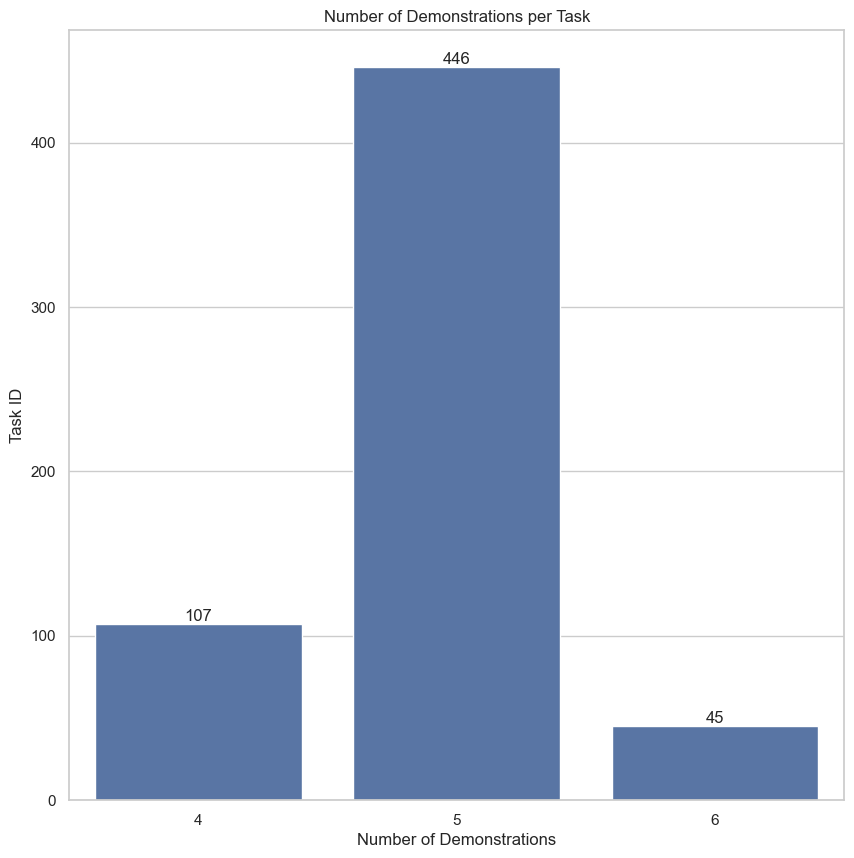

In [24]:
task_counts = df_valid['task_id'].value_counts()

# Stats
print(f"# of demonstrations: {task_counts.sum()}")
print(f"# of tasks: {task_counts.shape[0]}")
print(f"Mean # of demonstrations per task: {task_counts.mean()}")
print(f"# of unique tasks: {df_valid['task_id'].nunique()}")

# Plot horizontal bar plot of # of demonstrations per task
import matplotlib.pyplot as plt
import seaborn as sns
task_hist = task_counts.groupby(task_counts).count()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=task_hist.index, y=task_hist)
ax.bar_label(ax.containers[0])
plt.title('Number of Demonstrations per Task')
plt.xlabel('Number of Demonstrations')
plt.ylabel('Task ID')
plt.show()

## Gold Tasks

In [148]:
df_rankings

,rank,task_id,gdrive_link,path_to_dir,folder_name
0,1,0,https://drive.google.com/drive/folders/1P8uCcM...,/Users/michaelwornow/Desktop/demonstration-col...,0 @ 2023-12-25-15-10-58
1,2,0,https://drive.google.com/drive/folders/1C_xKhO...,/Users/michaelwornow/Desktop/demonstration-col...,0 @ 2024-01-08-14-57-29
2,3,0,https://drive.google.com/drive/folders/1uoHBYq...,/Users/michaelwornow/Desktop/demonstration-col...,0 @ 2024-01-13-04-37-18
3,4,0,https://drive.google.com/drive/folders/1fQQ0Sg...,/Users/michaelwornow/Desktop/demonstration-col...,0 @ 2023-12-25-16-43-12
4,5,0,https://drive.google.com/drive/folders/1PTXGxk...,/Users/michaelwornow/Desktop/demonstration-col...,0 @ 2024-01-05-01-55-35
...,...,...,...,...,...
719,1,810,https://drive.google.com/drive/folders/1MFwN0x...,/Users/michaelwornow/Desktop/demonstration-col...,810 @ 2024-01-03-01-50-10
720,2,810,https://drive.google.com/drive/folders/1p7UExu...,/Users/michaelwornow/Desktop/demonstration-col...,810 @ 2024-01-01-18-12-32
721,3,810,https://drive.google.com/drive/folders/1NDVzpt...,/Users/michaelwornow/Desktop/demonstration-col...,810 @ 2024-01-14-05-46-56
722,4,810,https://drive.google.com/drive/folders/1UStENS...,/Users/michaelwornow/Desktop/demonstration-col...,810 @ 2024-01-07-22-33-14


# of tasks: 162
# of rankings : 724
Mean # of rankings per task: 4.469135802469136


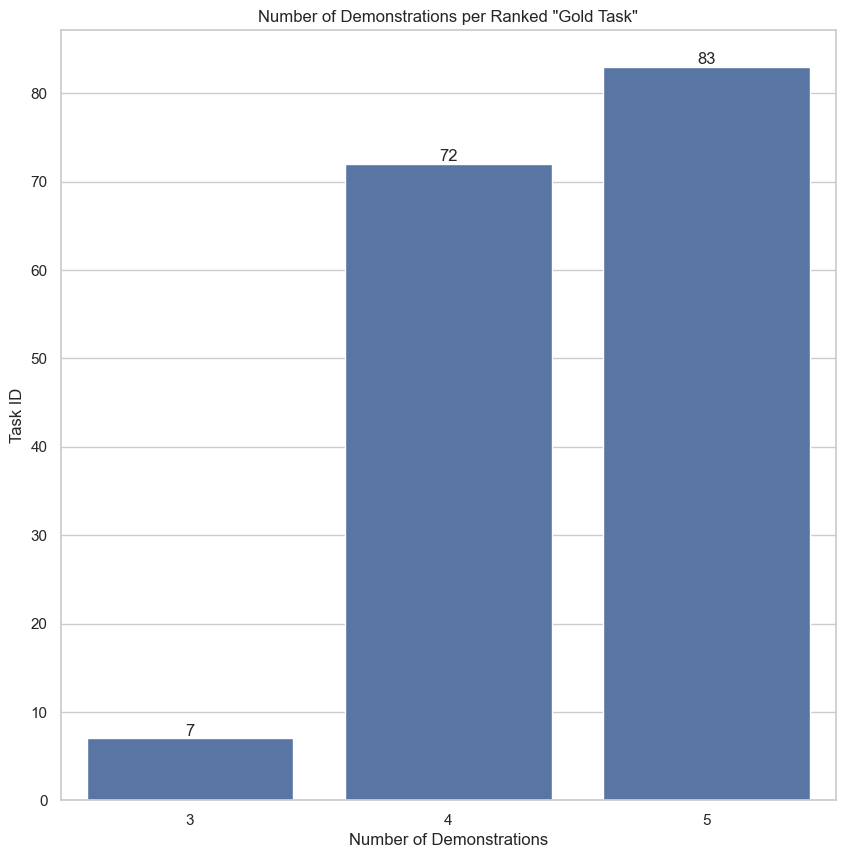

In [149]:
rank_counts = df_rankings['task_id'].value_counts()

# Stats
print(f"# of tasks: {df_rankings['task_id'].nunique()}")
print(f"# of rankings : {df_rankings.shape[0]}")
print(f"Mean # of rankings per task: {df_rankings.shape[0] / df_rankings['task_id'].nunique()}")

# Plot horizontal bar plot of # of demonstrations per task
import matplotlib.pyplot as plt
import seaborn as sns
task_hist = rank_counts.groupby(rank_counts).count()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=task_hist.index, y=task_hist)
ax.bar_label(ax.containers[0])
plt.title('Number of Demonstrations per Ranked "Gold Task"')
plt.xlabel('Number of Demonstrations')
plt.ylabel('Task ID')
plt.show()